In [28]:
%pylab inline
import sys,os
sys.path.insert(1,'../../python/')
from utils import * # COMAJE utilities
file_root='/mnt/store1/oliverphilcox/QPMCovarianceCanon/'

Populating the interactive namespace from numpy and matplotlib


#### Define QPM mock parameter class for matrix read-in

In [41]:
class QPM_Parameters:
    """Holds covariance matrix parameters for the QPM matrices. These are initially set to default values"""
    def __init__(self,mock_no,mean=False):
        self.n=39
        self.m=24
        self.a=1
        self.n_indiv=10
        if mean:
            self.infile_root=file_root+'Mean/'
            self.n_indiv=10
        else:
            self.infile_root=file_root+'Mock_%d/'%mock_no
        self.weights_file='/mnt/store1/oliverphilcox/QPM_weights/jackknife_weights_n39_m24_j169.dat'
        self.RR_file = '/mnt/store1/oliverphilcox/QPM_weights/binned_pair_counts_n39_m24_j169.dat'
        self.r_bins = np.loadtxt('/home/oliverphilcox/COMAJE/python/hybrid_binfile_cut.csv')         

## Load covariance with smooth $\xi$

In [42]:
p=QPM_Parameters(0,mean=True)
qpm_mean=CovarianceMatrix(p)

In [43]:
# Compute N_eff and precision matrix:
qpm_mean.compute_N_eff();
qpm_mean.compute_precision();

Total N_eff Estimate: 1.936052e+05


## Load noisy covariance matrices

In [44]:
noisy_cov=[]
for i in range(40):
    if os.path.exists(file_root+'Mock_%d'%i):
        p=QPM_Parameters(i)
        try:
            noisy_cov.append(CovarianceMatrix(p))            
        except OSError:
            continue
print("Read in %d noisy covariance matrices"%len(noisy_cov))

Read in 30 noisy covariance matrices


## Compare mean determinant per mode

In [45]:
def mean_det(cov_matrix):
    v=np.linalg.slogdet(cov_matrix.c_tot)[1]/(cov_matrix.n*cov_matrix.m)
    return np.exp(v)

smooth_mean_det=mean_det(qpm_mean)
noisy_mean_dets=[]
for i in range(len(noisy_cov)):
    noisy_mean_dets.append(mean_det(noisy_cov[i]))

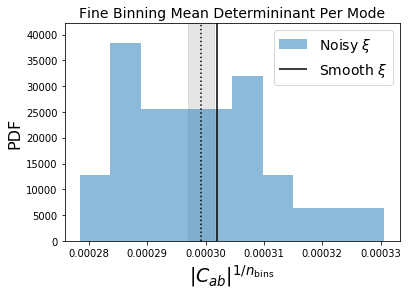

In [46]:
x,y,z=plt.hist(noisy_mean_dets,density=True,alpha=0.5,label=r'Noisy $\xi$')
plt.vlines(smooth_mean_det,0,max(x)*1.1,label=r'Smooth $\xi$');
mean,err=np.mean(noisy_mean_dets),np.std(noisy_mean_dets)/np.sqrt(len(noisy_mean_dets))
plt.vlines(np.mean(mean),0,max(x)*1.1,linestyles='dotted')
yvals=np.linspace(0,max(x)*1.1,100);FS=16
plt.ylim(0,max(x)*1.1)
plt.fill_betweenx(yvals,np.ones(100)*(mean-err),np.ones(100)*(mean+err),alpha=0.1,color='k')
plt.legend(fontsize=FS-2)
plt.title('Fine Binning Mean Determininant Per Mode',fontsize=FS-2)
plt.ylabel('PDF',fontsize=FS);plt.xlabel(r'$|C_{ab}|^{1/n_\mathrm{bins}}$',fontsize=FS+3);

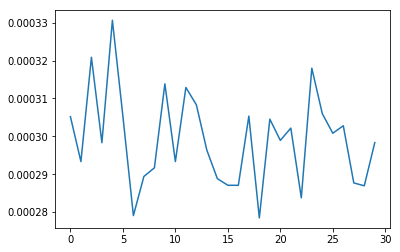

In [50]:
plt.plot(noisy_mean_dets)

Save determinant data:

In [47]:
np.savez('FineDeterminants.npz',noisy_determinants=noisy_mean_dets,noisy_indices=range(1,1+len(noisy_mean_dets)),
                                smooth_determinant=smooth_mean_det)

## Compare Diagonals for a noisy and smooth matrix:

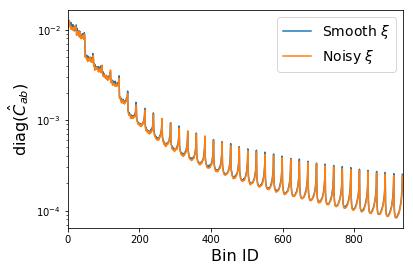

In [48]:
pt=plotting_tools()
fig=pt.plot_diagonal(qpm_mean,name=r'Smooth $\xi$')
pt.plot_diagonal(noisy_cov[1],fig=fig,name=r'Noisy $\xi$',legend=True);

Mean of 100 xi (top)
Single Matrix xi (bottom)


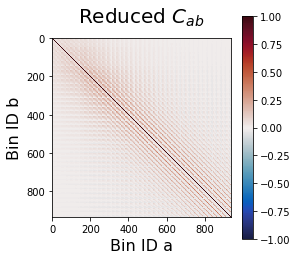

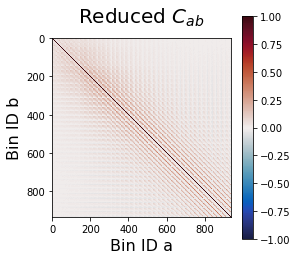

In [9]:
print('Mean of 100 xi (top)')
pt.plot_reduced_covariance(qpm_mean)
print('Single Matrix xi (bottom)')
pt.plot_reduced_covariance(noisy_cov[1])

## Compute KL divergence and $N_\mathrm{eff}$ estimates
Do this for a single noisy mock $\xi$ and using the smooth $\xi$ from 100 mocks/

First compute for the single high-resolution mock

In [11]:
partial_covs=[]
p=QPM_Parameters(1)
p.infile_root=file_root+'HiResMock_1/'
p.n_indiv=100
qpm_1=CovarianceMatrix(p)
i_min=5;i_max=p.n_indiv;i_step=5
for i in range(i_max):
    partial_covs.append(qpm_1.read_all_matrices(root=str(i)))
samples_indivs=list(np.arange(i_min,i_max,i_step))
N_effs_indivs,KL_div_indivs = [np.zeros(len(samples_indivs)) for _ in range(2)]
for j,ii in enumerate(samples_indivs):
    print("Computing D matrix %d of %d"%(ii,i_max))
    c_tot_mats=partial_covs[:ii]
    nn = len(c_tot_mats)
    summ=0.
    for i in range(nn):
        c_excl_i = np.mean(c_tot_mats[:i]+c_tot_mats[i+1:],axis=0)
        summ+=np.matmul(np.linalg.inv(c_excl_i),c_tot_mats[i])
    D_est = (nn-1.)/nn*(-1.*np.eye(len(c_tot_mats[0]))+1./nn*summ)
    slogdetD=np.linalg.slogdet(D_est)
    n_bins = len(D_est)
    D_value = slogdetD[0]*np.exp(slogdetD[1]/n_bins)
    N_effs_indivs[j] = (n_bins+1.)/D_value+1.
    KL_div_indivs[j] = KL_divergence(qpm_mean.prec,np.mean(c_tot_mats,axis=0))

Computing D matrix 5 of 100
Computing D matrix 10 of 100
Computing D matrix 15 of 100
Computing D matrix 20 of 100
Computing D matrix 25 of 100
Computing D matrix 30 of 100
Computing D matrix 35 of 100
Computing D matrix 40 of 100
Computing D matrix 45 of 100
Computing D matrix 50 of 100
Computing D matrix 55 of 100
Computing D matrix 60 of 100
Computing D matrix 65 of 100
Computing D matrix 70 of 100
Computing D matrix 75 of 100
Computing D matrix 80 of 100
Computing D matrix 85 of 100
Computing D matrix 90 of 100
Computing D matrix 95 of 100


In [12]:
N_bins=len(qpm_mean.prec)
N_eff_KL_indiv = [N_bins*(N_bins+1)/(4.*KL) for KL in KL_div_indivs]

Plot true $N_\mathrm{eff}$ (measuring in-matrix noisy level) against $N_\mathrm{eff,KL}$ (measuring expected noise if a noisy realization of the smooth $\xi$ covariance matrix).

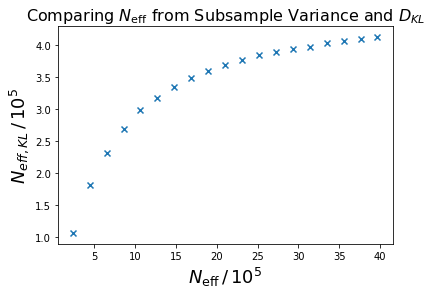

In [13]:
plt.scatter(N_effs_indivs/1e5,np.asarray(N_eff_KL_indiv)/1e5,marker='x');
plt.ylabel(r'$N_{eff,KL}\,/\,10^5$',fontsize=18);plt.xlabel(r'$N_\mathrm{eff}\,/\,10^5$',fontsize=18)
plt.title(r'Comparing $N_\mathrm{eff}$ from Subsample Variance and $D_{KL}$',fontsize=16);
#plt.savefig("../../plots/N_eff_Subsample.pdf",bbox_inches='tight')

In [14]:
D_from_N_eff=[N_bins*(N_bins+1)/(4.*Ne) for Ne in N_effs_indivs]

Plot the expected KL divergence between the noisy and smooth matrix (if the noisy matrix is a realization from the smooth matrix distribution) and the true KL divergence.

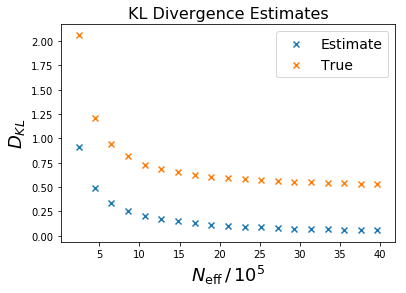

In [15]:
plt.scatter(N_effs_indivs/1e5,np.asarray(D_from_N_eff),marker='x',label='Estimate');
plt.scatter(N_effs_indivs/1e5,np.asarray(KL_div_indivs),marker='x',label='True');
plt.xlabel(r'$N_\mathrm{eff}\,/\,10^5$',fontsize=18);plt.ylabel(r'$D_{KL}$',fontsize=18);plt.legend(fontsize=14)
plt.title(r'KL Divergence Estimates',fontsize=16);
#plt.savefig("../../plots/D_KL_vs_Estimate.pdf",bbox_inches='tight')

In [23]:
plateau=0.5
N_eff_plateau = (N_bins*(N_bins+1.))/(4.*plateau)
print("%.2e"%N_eff_plateau)

4.39e+05


We note a clear plateau in $D_\mathrm{KL,true}\approx0.5$, with corresponding $N_\mathrm{eff}\sim5\times10^5$. Thus using a noisy $\xi$ is good if we want effective mock numbers considerably less than this.

Save the dataset:

In [16]:
np.savez('NoisySmooth_KLdiv_N_eff_data.npz',N_eff_true=N_effs_indivs,
        KL_div_true=KL_div_indivs,N_eff_from_KL=N_eff_KL_indiv,
        KL_div_from_N_eff=D_from_N_eff)